# Winnie-the-Pooh 🐻🍯  
## Retrieval-Augmented Generation (RAG) Hands-on Task


### Karin Brisker
<img src="https://media-cldnry.s-nbcnews.com/image/upload/t_fit-760w,f_auto,q_auto:best/rockcms/2024-03/winnie-the-pooh-quotes-sc-031224-01-032f24.jpg" alt="Winnie-the-Pooh" style="width:0.00001%;"/>

## Task Objective
Your primary goal is to enhance the model's accuracy in answering questions about A. A. Milne's beloved classic, "Winnie-the-Pooh". You will achieve this by experimenting with various techniques and parameters to see their impact on performance.

## Retrieval-Augmented Generation (RAG)
Retrieval-Augmented Generation (RAG) is a powerful technique that combines retrieval and generation to produce more accurate and contextually relevant answers. Here’s how it works:

1. **Retrieval**:
   - A retriever model fetches relevant documents or text sections from a large corpus based on the input query.

2. **Augmented Generation**:
   - The retrieved documents are fed into a generative model to produce the final answer.
   - This helps the model leverage external knowledge and provide more accurate responses.

### Potential Pitfalls of RAG Models
- **Inaccurate Retrieval**: The retriever might fetch irrelevant or incorrect context, leading to wrong answers. Ensure your retrieval mechanism is well-tuned and accurate.
- **Complex Prompts**: Overly complex prompts can confuse the model, resulting in lower accuracy. Keep your prompts clear and concise.
- **Bias in Training Data**: The model's performance can be influenced by biases present in the training data. Be aware of this and consider using bias mitigation techniques if necessary.
- **Latency Issues**: Retrieval and generation can introduce latency. Optimize your code to minimize delays.

### Prompt Engineering Tips
- **Contextual Prompts**: Ensure your prompts provide enough context for the model to understand the question. This can significantly affect the accuracy of the answers.
- **Specificity**: Be specific in your prompts to guide the model towards the correct answer.
- **Experimentation**: Try different prompt structures to see which ones yield the best results.

## Installing Dependencies

**This section installs the required libraries:**
* **LangChain:** A framework for building applications with language models.
* **Accelerate:** A library to accelerate PyTorch models.
* **Bits and Bytes (bnb):** A library for model quantization.
* **Transformers:** A library by Hugging Face that provides various pretrained models.
* **Sentence-Transformers:** A library for sentence embeddings.
* **FAISS:** A library for efficient similarity search and clustering of dense vectors.

### 1. Setup and Installation
First, we need to install the necessary libraries and log in to Hugging Face.

In [33]:
# Install necessary libraries
!pip install -qU langchain accelerate bitsandbytes transformers sentence-transformers faiss-gpu
!pip install -qU langchain-community

## Authenticating with Hugging Face
We need to authenticate with the Hugging Face Hub to access models and datasets. Ensure you replace the token with your own.

[See here](https://huggingface.co/docs/hub/en/security-tokens)

In [34]:
from huggingface_hub import login
login(token="PLACE_YOUR_TOKEN_HERE") # User_Access_Token

The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: read).
Your token has been saved to /root/.cache/huggingface/token
Login successful


### 2. Import Required Libraries
Now, let's import all the necessary libraries and modules.

### 3. Load and Configure the Language Model
We'll use the Mistral-7B-Instruct-v0.1 model for our QA system. This step involves loading the model and configuring it for efficient use.

In [35]:
# Import required libraries and modules
import os
from glob import glob
from tqdm import tqdm

import transformers
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
)

from langchain.embeddings.huggingface import HuggingFaceEmbeddings
from langchain.vectorstores import FAISS
from langchain.chains import LLMChain
from langchain.schema.runnable import RunnablePassthrough
from langchain.llms import HuggingFacePipeline
from langchain.prompts import PromptTemplate
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

 ## Initialize Model and Tokenizer with BitsAndBytes Configuration
 We configure Bits and Bytes for efficient model loading, allowing us to use a 4-bit quantized model. This significantly reduces the model size and improves performance.
### To Initial Minstral Model
[We need to enter the model page in Hugging Face and we have to accept the conditions to access its files and content.](https://huggingface.co/mistralai/Mistral-7B-Instruct-v0.1)

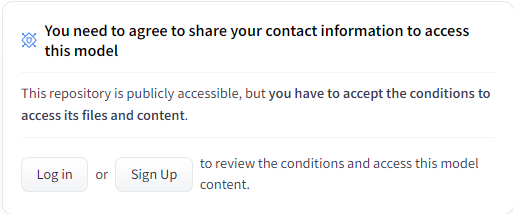

In [36]:
# Configure BitsAndBytes for efficient model loading
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype="float16",
    bnb_4bit_use_double_quant=False,
)

# Load the model with the above configuration
model = AutoModelForCausalLM.from_pretrained(
    "mistralai/Mistral-7B-Instruct-v0.1",
    quantization_config=bnb_config,
    do_sample=True,
)

# Initialize tokenizer and set padding
tokenizer = AutoTokenizer.from_pretrained("mistralai/Mistral-7B-Instruct-v0.1")
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

`low_cpu_mem_usage` was None, now set to True since model is quantized.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

* **Bits and Bytes Configuration:** This configuration allows the model to be loaded efficiently using 4-bit quantization.
* **AutoModelForCausalLM:** Loads a causal language model.
* **AutoTokenizer:** Initializes the tokenizer for the model.

## Set up Text Generation Pipeline
We set up the text generation pipeline with specific parameters to control the output, such as temperature and repetition penalty.

In [37]:
# Set up the text generation pipeline with specific parameters
text_generation_pipeline = transformers.pipeline(
    model=model,
    tokenizer=tokenizer,
    task="text-generation",
    repetition_penalty=1.1,
    return_full_text=False,
    max_new_tokens=256,
    do_sample=True,
)

# Create a HuggingFacePipeline instance for text generation
mistral_llm = HuggingFacePipeline(pipeline=text_generation_pipeline)

* **Pipeline:** Sets up the text generation pipeline with parameters like temperature and repetition penalty.
* **HuggingFacePipeline:** Wraps the text generation pipeline for use in LangChain.

### 5. Download and Preprocess the Book Text
Now, we'll download the text of "Winnie-the-Pooh" from and preprocess it for our QA system.

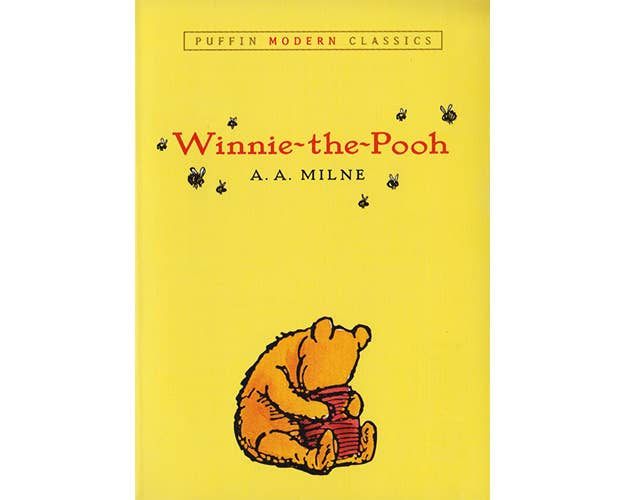



In [38]:
import requests

# Fetch the text of "Winnie-the-Pooh" from Project Gutenberg
url = "https://www.gutenberg.org/files/67098/67098-0.txt"
response = requests.get(url)
text = response.text

# Preprocess the text
# Extract the main content of the book
text_start = text.find("Here is Edward Bear")
text_end = text.find("THE END")
book_text = text[text_start:text_end].strip()

# Verify the extracted text
print("First 300 characters of the book:\n", book_text[:300])

# Calculate and print the length of the extracted text
print("Length of the book text:", len(book_text))

First 300 characters of the book:
 Here is Edward Bear, coming downstairs now, bump, bump, bump, on the
back of his head, behind Christopher Robin. It is, as far as he knows,
the only way of coming downstairs, but sometimes he feels that there
really is another way, if only he could stop bumping for a moment and
think of it. And then
Length of the book text: 141554


### 6. Define Test Set
We'll create a test set of question-answer pairs about the book to evaluate our QA system.

In [39]:
test_set = [
    {"question": "Who is Pooh Bear's best friend?", "answer": "Piglet"},
    {"question": "Why does Winnie the Pooh not like heffalumps?", "answer": "Because they want to take his honey"},
    {"question": "What is Winnie the Pooh's favorite food?", "answer": "Honey (or Hunny)"},
    {"question": "Which character is wise?", "answer": "Owl"},
    {"question": "Who calls Pooh a 'silly old bear'?", "answer": "Christopher Robin"},
    {"question": "Who is the youngest in the Hundred Acre Wood?", "answer": "Roo"},
    {"question": "What kind of animal is Eeyore?", "answer": "A donkey"},
    {"question": "What was Winnie the Pooh's original name?", "answer": "Edward"},
    {"question": "What does Piglet do when he is afraid of something?", "answer": "He stutters but also shakes and blushes"},
    {"question": "What is Tigger's most famous catchphrase?", "answer": "Name's Tigger. T-I-double guh-er!"},
    {"question": "Where does Pooh go to think?", "answer": "His Thoughtful Spot"},
    {"question": "Who is the only girl character?", "answer": "Kanga"},
    {"question": "What is Eeyore's house called?", "answer": "Gloomy Place"},
    {"question": "What is Rabbit's favorite vegetable?", "answer": "Carrots"},
    {"question": "How does Owl spell his name?", "answer": "Wol"},
    {"question": "What is Piglet's catchphrase?", "answer": "Oh, D-D-Dear!"},
    {"question": "What color bow sits at the end of Eeyore's tail?", "answer": "A pink bow"},
    {"question": "What does Winnie the Pooh say when he wakes up?", "answer": "What's for breakfast?"},
    {"question": "What is Piglet's favorite food?", "answer": "Acorns (or Haycorns)"},
    {"question": "What did Christopher Robin say he liked to do best?", "answer": "Go on adventures"},
    {"question": "What is Tigger afraid of?", "answer": "Heights"},
    {"question": "Which character does Rabbit dislike?", "answer": "Tigger"},
    {"question": "Where does Roo like to play?", "answer": "The sandy pit"},
    {"question": "Where do Winnie the Pooh and friends live?", "answer": "Hundred Acre Wood"},
    {"question": "Piglet doesn’t mind the leaves that are leaving, but what does he not like?", "answer": "The leaves that are coming"},
    {"question": "What is Tigger's favorite thing to do?", "answer": "Bounce"},
    {"question": "What part of Rabbit’s house is impassable?", "answer": "The entrance"}
    {"question": "How does Winnie-the-Pooh come downstairs?", "answer": "Bump, bump, bump on the back of his head."},
    {"question": "What does Christopher Robin call Winnie-the-Pooh?", "answer": "Winnie-ther-Pooh."},
    {"question": "Where does Winnie-the-Pooh live?", "answer": "In a forest."},
    {"question": "What does the buzzing-noise in the tree signify to Pooh?", "answer": "That the bees are making honey."},
    {"question": "Why does Pooh climb the tree?", "answer": "To get honey."},
    {"question": "What does Pooh do while climbing the tree?", "answer": "Sings a little song."},
    {"question": "What does Pooh look like holding on to the balloon?", "answer": "A bear holding on to a balloon."},
    {"question": "What does Pooh think he should look like to deceive the bees?", "answer": "A small black cloud."},
    {"question": "What does Christopher Robin fetch for Pooh to help with the deception?", "answer": "An umbrella."},
    {"question": "What does Pooh ask Christopher Robin to do with the gun?", "answer": "Shoot the balloon."},
    {"question": "Who does Pooh go to visit when he gets stuck in Rabbit's hole?", "answer": "Rabbit."},
    {"question": "What time does Pooh like a little something?", "answer": "Eleven o'clock in the morning."},
    {"question": "What does Rabbit suggest to do to get Pooh out of the hole?", "answer": "Fetch Christopher Robin."},
    {"question": "What does Christopher Robin say they need to do to get Pooh out?", "answer": "Wait for him to get thin."},
    {"question": "What does Pooh decide to do after noticing multiple tracks?", "answer": "Follow them."},
    {"question": "What does Piglet do when he gets scared while tracking?", "answer": "Trots off home."},
    {"question": "What happens to Piglet's balloon?", "answer": "It bursts."},
    {"question": "What does Piglet mistake for a Heffalump?", "answer": "Pooh with a jar on his head."},
    {"question": "What is Eeyore's birthday present from Pooh?", "answer": "A Useful Pot."},
    {"question": "What does Eeyore do with Piglet's balloon?", "answer": "Puts it in the pot."},
    {"question": "What does Kanga do when she realizes Piglet is in her pocket?", "answer": "Gives him a bath."},
    {"question": "Who is Edward Bear?", "answer": "Winnie-the-Pooh"},
    {"question": "What is the only way Edward Bear knows to come downstairs?", "answer": "Bumping on his head"},
    {"question": "What name is over Winnie-the-Pooh's door?", "answer": "Sanders"},
    {"question": "What do bees make?", "answer": "Honey"},
    {"question": "What does Winnie-the-Pooh ask Christopher Robin for?", "answer": "A balloon"},
    {"question": "Who is the main listener of the stories?", "answer": "Christopher Robin"},
]

### 7. Define Evaluation Functions
These functions will help us answer questions and evaluate our model's performance.

In [52]:
def answer_question(question, model, retriever, llm_chain):
    # Use the retriever to find relevant context for the question
    context = retriever.get_relevant_documents(question)
    # Use the language model to generate an answer based on the context
    input_data = {"question": question, "context": context}

    answer = llm_chain.run(input_data)
    return answer

def evaluate_model(test_set, model, use_retriever=False, retriever=None, llm_chain=None):
    total_questions = len(test_set)
    correct_answers = 0

    for item in test_set:
        question = item["question"]
        correct_answer = item["answer"]

        # Get the model's answer
        if use_retriever and retriever and llm_chain:
            model_answer = answer_question(question, model, retriever, llm_chain)
        else:
            model_answer = model(question)

        # Print the question, correct answer, and model's answer for verification
        print(f"Question: {question}")
        print(f"Correct Answer: {correct_answer}")
        print(f"Model Answer: {model_answer}")

        # Check if the model's answer is correct
        if model_answer.strip().lower() in correct_answer.strip().lower():
            print("Correct!")
            correct_answers += 1
        else:
            print("Wrong!")

        print("-" * 30)

    # Calculate and return accuracy
    accuracy = correct_answers / total_questions
    return accuracy

### 8. Create Prompt Template
We'll define a prompt template for generating answers.

In [41]:
# Define the prompt template for generating text
prompt_template = """
Instruction: prompt=f"Answer the following question concisely based only on the provided context:{context}
If the answer does not appear in the context, answer: \"The answer isn't in the data you supplied\""

Question:
{question}

Answer:
"""

prompt = PromptTemplate(
   input_variables=["context", "question"],
   template=prompt_template,
)


### 9. Create Language Model Chain
Now, we'll create a language model chain using our Mistral model and the prompt template.

In [42]:
llm_chain = LLMChain(llm=mistral_llm, prompt=prompt)

### 10. Preprocess Book Text for Retrieval
We'll further preprocess the book text by splitting it into sections for efficient retrieval.

In [43]:
# Further preprocessing
# Replace multiple newlines with a single newline to standardize spacing
book_text = book_text.replace('\r\n', '\n').replace('\r', '\n').strip()

# Split the text into lines
lines = book_text.split('\n')

# Remove empty lines
lines = [line.strip() for line in lines if line.strip()]

# Group lines into sections of 10 lines each
sections = ['\n'.join(lines[i:i + 10]) for i in range(0, len(lines), 10)]

# Print the first few sections to verify
for i, section in enumerate(sections[:5]):
    print(f"Section {i+1}:\n{section}\n{'-'*40}")

Section 1:
Here is Edward Bear, coming downstairs now, bump, bump, bump, on the
back of his head, behind Christopher Robin. It is, as far as he knows,
the only way of coming downstairs, but sometimes he feels that there
really is another way, if only he could stop bumping for a moment and
think of it. And then he feels that perhaps there isn't. Anyhow, here he
is at the bottom, and ready to be introduced to you. Winnie-the-Pooh.
When I first heard his name, I said, just as you are going to say, "But
I thought he was a boy?"
"So did I," said Christopher Robin.
"Then you can't call him Winnie?"
----------------------------------------
Section 2:
"I don't."
"But you said----"
"He's Winnie-ther-Pooh. Don't you know what '_ther_' means?"
"Ah, yes, now I do," I said quickly; and I hope you do too, because it
is all the explanation you are going to get.
Sometimes Winnie-the-Pooh likes a game of some sort when he comes
downstairs, and sometimes he likes to sit quietly in front of the fire
and 

### 11. Create Embeddings and FAISS Index
We'll create embeddings for our text sections and build a FAISS index for efficient retrieval.

In [44]:
# Index the processed documents with FAISS for efficient retrieval
db = FAISS.from_texts(
    sections,
    HuggingFaceEmbeddings(model_name='sentence-transformers/all-mpnet-base-v2')
)

# Convert the FAISS index into a retriever
retriever = db.as_retriever(
    search_type="similarity",
    search_kwargs={"k": 5},
    )


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


### 12. Save and Load Retriever
To avoid recomputing the embeddings and index each time, we'll save our retriever to disk.

In [45]:
import pickle

def save_object(obj, filename):
    with open(filename, 'wb') as outp:  # Overwrites any existing file.
        pickle.dump(obj, outp, pickle.HIGHEST_PROTOCOL)

def load_object(filename):
    with open(filename, 'rb') as inp:  # Open the file in binary read mode
        obj = pickle.load(inp)
    return obj

# Save the retriever
save_object(retriever, 'pooh_retriever.pkl')

# Load the retriever
loaded_retriever = load_object('pooh_retriever.pkl')

### 13. Evaluate the Model
Finally, we'll evaluate our model's performance using the test set and the retriever.

In [53]:
# Evaluate the model using the retriever
accuracy = evaluate_model(test_set, mistral_llm, use_retriever=True, retriever=loaded_retriever, llm_chain=llm_chain)
print(f"Model accuracy: {accuracy:.2%}")

Question: Who is Pooh Bear's best friend?
Correct Answer: Piglet
Model Answer: Christopher Robin
Wrong!
------------------------------
Question: Why does Winnie the Pooh not like heffalumps?
Correct Answer: Because they want to take his honey
Model Answer: Winnie the Pooh does not like Heffalumps because he remembers putting one in a trap to catch it but could not sleep afterwards due to the image of the Heffalump eating all the honey.
Wrong!
------------------------------
Question: What is Winnie the Pooh's favorite food?
Correct Answer: Honey (or Hunny)
Model Answer: According to the given input documents, it is mentioned that Pooh always likes a little something at eleven o'clock in the morning. When asked what he would like to have, he says "Both" for honey and condensed milk. Additionally, during the conversation between Pooh and Christopher Robin in The Floating Bear, Pooh mentions that he would like honey. However, it should be noted that specific foods mentioned in the document

## Task

#### Improve the Model's Accuracy - It's Your Time to Shine 🌞

### Objective
Your task is to improve the overall accuracy of the model in answering questions about "*Winnie-the-Pooh*". You will evaluate the model's accuracy using a predefined test set of questions and answers.

### Suggested Next Steps for Improvement

1. **Text Preprocessing:**
    - Experiment with different text preprocessing techniques.
    - Adjust the size of text sections for FAISS indexing. Smaller or larger sections might impact retrieval performance.

2. **Embedding Models:**
    - Test different embedding models from HuggingFace and compare their performance.

3. **Retriever Configuration:**
    - Adjust FAISS index parameters if applicable.
    - Explore different index types or configurations that might improve retrieval accuracy.

4. **Model and Chain Configuration:**
    - Optimize the configuration of your language model and the chain used to generate answers.
    - Ensure that the context length, number of retrieved documents, or any other parameters are set optimally.

5. **Prompt Engineering:**
    - Experiment with different prompt structures and formulations to see how they affect the quality of the generated answers.

6. **Evaluation Metrics:**
    - Change the evaluation metrics in ```evaluate_model```, from exact match to embedding-based approaches, to assess the performance of your system comprehensively.



**Please remember to document your process and findings in the notebook.**

Good luck, and have fun 😸

Karin
